In [2]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [3]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/16h5/s_yaw_16h5_2m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [4]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [5]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,25.541046
1,0.987709,34.322809
2,0.987742,14.342188
3,1.771374,31.282950
4,2.623864,14.364782
...,...,...
330,112.167772,74.517263
331,112.464301,74.455190
332,112.895325,74.755862
333,113.256053,71.017223


<AxesSubplot:xlabel='relative_time'>

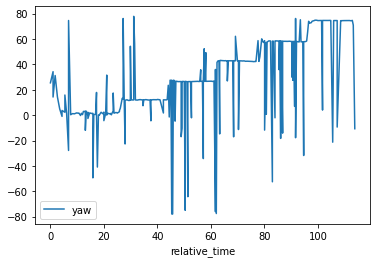

In [6]:
# initial graph
df.plot(x='relative_time', y=target)

In [7]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 10)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [8]:
# the amount of data points we are left with
len(x[peaks])

48

In [9]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

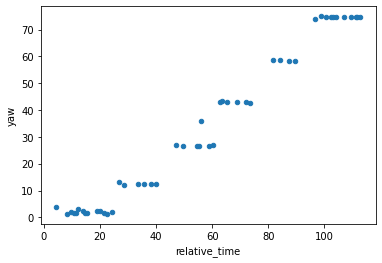

In [10]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [11]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(np.fix(df_filtered_by_targets[target]), len(input_vals)+2, labels=input_vals, duplicates='drop')

In [12]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [13]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [14]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [15]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
15,8.227692,1.248493,0,-1.248493
17,9.811062,1.814782,0,-1.814782
76,28.641359,12.169825,15,2.830175
92,33.520924,12.323212,15,2.676788
132,47.252718,26.800424,30,3.199576
139,49.597683,26.656382,30,3.343618
159,56.206071,35.811331,45,9.188669
183,62.717164,42.908334,45,2.091666
239,81.666340,58.597664,60,1.402336
247,84.307770,58.602944,60,1.397056


In [16]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,13.0,-1.889963,0.509512,-2.994214,-2.304319,-1.750822,-1.540559,-1.248493
15,5.0,2.710729,0.091308,2.582876,2.676788,2.713379,2.750428,2.830175
30,6.0,3.265049,0.070802,3.164719,3.216974,3.276336,3.318160,3.343618
45,4.0,3.967653,3.483339,2.091666,2.155533,2.295138,4.107257,9.188669
60,4.0,1.542684,0.165160,1.397056,1.401016,1.541860,1.683529,1.689961
75,11.0,0.346392,0.218465,0.070507,0.245785,0.319678,0.365077,0.949141


In [17]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

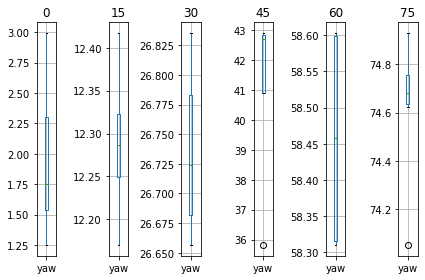

In [18]:
box_plotter(target)

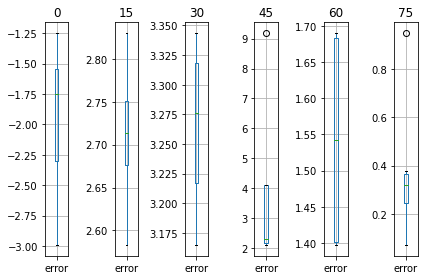

In [19]:
box_plotter('error')

In [20]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/2m_16h5_1080.csv')